## COMP41680 -  Assignment No 2

## Nikita Ravindra Gavand- Student No:19200184 

In [1]:
#All the required imports are placed in this section
import urllib
import bs4
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import cross_val_score, RepeatedKFold
import matplotlib.pyplot as 
from sklearn.decomposition import PCA

In [2]:
# Fetching the data from the link given
link = "http://mlg.ucd.ie/modules/yalp/"
response = urllib.request.urlopen(link)

## Data scraping

The method of loading data from a website in a tablet or local file that is saved on your computer, is the scraping method. It is often called web scraping. That is one of the most successful ways of getting web data and funnel it into another website in some cases.


Here we have collected the data from http://mlg.ucd.ie/modules/yalp/ and then we have to extract the data from the html code
I have used beautifulSoup to parse the HTML file and extract the data from a particular tag

In [3]:
data = response.read().decode()
# splitting the data to fetch the each tag's data 
lines = data.strip().split("\n")
response = urllib.request.urlopen(link)
# Now these lines consist of raw html code from we have to parse and extract the data

In [4]:
# We have multiple links on the above given link 
all_links = []
parser = bs4.BeautifulSoup(data,"html.parser")
# Finding all the anchor tags and appending on the link given above to fetch the actual data in that link
for get_link in parser.findAll('a'):
                all_links.append(get_link.get('href'))

## Selecting three review categories : Cafe, Hotel, Restaurant
Here we have 7 types of data 
I have choosen this dataset because they are related to each other and will be good for comparision
The data consist of the reviews and ratings from the user

In [5]:
#Appends the html file on the above website of all the links and picking up the comments of each reviewer
all_links = [link+all_links[1],link+all_links[6], link+all_links[7]]
sublinks=[]
for l in all_links:
        a=[]
        response = urllib.request.urlopen(l)
        html = response.read().decode()
        parser = bs4.BeautifulSoup(html,"html.parser")
        for get_link in parser.findAll('a'):
                a.append(get_link.get('href'))
        sublinks.append(a)
#Concatenate the link and the sublinks
sublinks = [ [link+c for c in a] for a in sublinks]

For building a classification model we are required to get the data in a datatframe to process further

In [6]:
# Creating the dataframe for each category
df=[] 
i=0
for data in sublinks:
        e=[] 
        rat=[] 
        for d in data:
            response = urllib.request.urlopen(d)
            html = response.read().decode()
            parser = bs4.BeautifulSoup(html,"html.parser")
            for linkk in parser.findAll('p',class_='review-text'):
                                e.append(linkk.text)
            for ratings in parser.findAll('img'):
                if ratings.get('alt')!=None:
                    if int(ratings.get('alt')[0])<4: 
                        rat.append('Negative')
                    else:
                        rat.append('Positive')
        df.append(pd.DataFrame(e))
        df[i]['Ratings']=rat
        i=i+1

## Task 1 : Data preprocessing 

We usually talk about certain large data sets with large numbers of rows and columns when we talk about data. While this is a potential scenario, it's not necessary, The data can be organized tables, images, audio files, videos etc.and in all kinds of different forms. Free text, image, or video data are not known to models. So it's probably not good enough if we put all our images on a slideshow and expect our model to do on his own.

Data processing needs raw data to be converted into an understandable format. Real data in the world are always incomplete, inconsistent and/or missing in other habits or patterns and may have several mistakes.

The following are the steps which can be performed in preprocessing

In [7]:
#Renaming the comments columns
df[0].rename(columns={0: 'Comments'}, inplace = True)
df[1].rename(columns={0: 'Comments'}, inplace = True)
df[2].rename(columns={0: 'Comments'}, inplace = True)

In [8]:
#Visualising the data frames of all the three categories
cafe_data = df[0]
hotel_data = df[1]
restaurant_data = df[2]
#The cafe data frame
cafe_data.head()

,Comments,Ratings
0,The man that was working tonight (8-12-17) was...,Negative
1,Chris is a very rude person. Gave me an attitu...,Negative
2,One of my favorite gas station to stop at. The...,Positive
3,Oh thank Heaven for Seven Eleven! I don't know...,Negative
4,Five stars because of the guy who works weekda...,Positive


In [9]:
#Second Data set which i have taken is a hotel dataset
hotel_data.head()

,Comments,Ratings
0,Melissa took us on a tour of Asia in the space...,Positive
1,With a group of seven of us visiting Montreal ...,Positive
2,Melissa is a gem! My fiancé found her tour on ...,Positive
3,A perfect day in Montreal! Melissa outfitted u...,Positive
4,I had a really great food truck tour with Meli...,Positive


In [10]:
#This is the restaurant dataset
restaurant_data.head()

,Comments,Ratings
0,My husband and I had a rare afternoon off so w...,Negative
1,For years I thought this was only a wine store...,Positive
2,This place is so charming! I went with my husb...,Positive
3,We have been wanting to try this place for a c...,Positive
4,Decor looks ok but layout is too busy. Difficu...,Negative


In [83]:
# Storing the data in csv file
hotel_data.to_csv('Hotel_data.csv', index = False)
restaurant_data.to_csv('Restaurant_data.csv', index = False)
cafe_data.to_csv('Cafe_data.csv', index = False)

Preprocessing consist of the following steps:
1. Removal of stopwords
2. Tokenization
3. Removing the punctuation
4. Stemming to the root words


In [11]:
def preprocess(review_list):
    preprocessed_sent=list()
    for review in review_list:    
        text_tokens = word_tokenize(review) # tokenising the text messages
        tokens_lower = [item.lower() for item in text_tokens] # Lower casing the words for uniformity
        tokens_without_sw = [word for word in tokens_lower if not word in stopwords.words('english')]# Removing the stopwords
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens_without_sw]# Removing the punctuation marks
        tokens_without_whitespace = [word.strip() for word in stripped] # Removing the whitespace before and after the words
        #Here we have used porter stemming to stem the words in the array list
        ps = PorterStemmer()
        tokens_with_stem = [ps.stem(word) for word in stripped]
        preprocessed_sent.append(' '.join(word for word in tokens_with_stem)) #stemming the words
    return preprocessed_sent

In [36]:
# Factorize to only numerical data
cafe_data['Review'] = cafe_data['Ratings'].factorize()[0]
hotel_data['Review'] = df[1]['Ratings'].factorize()[0]
restaurant_data['Review'] = df[2]['Ratings'].factorize()[0]
# Creating a dictionaries to save the expected lable 0 as positive and 1 as negative which is only numerical data
Review_df = cafe_data[['Ratings', 'Review']].drop_duplicates().sort_values('Review')
category_to_id = dict(Review_df.values)
Review = dict(Review_df[['Review', 'Ratings']].values)

TF-IDF is a numerical information that represents the value of a word in a text or corpus. The tf – idf value increases according to the amount of times a word appears on the document and is balanced by the number of documents in the corpus containing the word that make it possible to adapt to the fact that certain terms appear more frequently. tf – idf is one of the most common terminology weightings

In [13]:
#Creating an array from the cafe dataframe for each dataset to get the feature names
vectorizer1 = TfidfVectorizer()
X1 = vectorizer1.fit_transform(preprocess(cafe_data['Comments'].to_list()))
dfcafe_review = pd.DataFrame(X1.toarray(), columns=vectorizer1.get_feature_names())
cafe_data['ReviewArray']=pd.DataFrame({0: dfcafe_review.to_numpy().tolist()})

In [14]:
#Creating an array from the hotel dataframe for each dataset to get the feature name
vectorizer2 = TfidfVectorizer()
X2 = vectorizer2.fit_transform(preprocess(hotel_data['Comments'].to_list()))
dfhotels_review = pd.DataFrame(X2.toarray(), columns=vectorizer2.get_feature_names())
hotel_data['ReviewArray']=pd.DataFrame({0: dfhotels_review.to_numpy().tolist()})

In [15]:
#Creating an array from the restaurant dataframe for each dataset to get the feature name
vectorizer3 = TfidfVectorizer()
X3 = vectorizer3.fit_transform(preprocess(restaurant_data['Comments'].to_list()))
dfrestaurant_review = pd.DataFrame(X3.toarray(), columns=vectorizer3.get_feature_names())
restaurant_data['ReviewArray']=pd.DataFrame({0: dfrestaurant_review.to_numpy().tolist()})

## Task 2:  Building a classification model to distinguish between “positive” and “negative”
I have used logistic regression model for this dataset
The predictive analysis of a data is called as logistic regression. Logistic regression is used in the classification and interpretation of data between a binary variable depending on the data and one or more different absolute, ordinal, interval or ratio level variables. When the dependent variable(target) is categorical, logistic regression is used.Data are fitted to the linear regression model, which is then followed by a logistic feature that predicts the categorically dependent variable target.

We will now build the classification model for cafe data

In [60]:
#Building a model for cafe data by fetching the apropriate data required
X_cafe_data=dfcafe_review
Y_cafe_data=cafe_data['Ratings']
# Spliting the data, ito two parts which is 70% in the training set and 30% in the test set:
X_train_cafe, X_test_cafe, y_train_cafe, y_test_cafe = train_test_split(X_cafe_data, Y_cafe_data, random_state=0, test_size = 0.30)
my_model_cafe = linear_model.LogisticRegression()
my_model_cafe.fit(X_train_cafe,y_train_cafe)
# Make a set of predictions for the test data
y_pred_cafe = my_model_cafe.predict(X_test_cafe)

In [62]:
# Accuracy of the data set
accuracy = metrics.accuracy_score(y_test_cafe, y_pred_cafe) # , normalize=True, sample_weight=None
print("Accuracy of cafe data " +  str(accuracy))

# confusion matrix show all the values such as TP, TN, FP,and FN. Also all the aggregate values 
print("Confusion Matrix of cafe data")
pd.crosstab(y_test_cafe, y_pred_cafe, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8983333333333333
Confusion Matrix


Predicted,Negative,Positive,All
True,,,
Negative,196,47,243
Positive,14,343,357
All,210,390,600


In [73]:
# Prints all the metrics report for classification
print("Classification Report :\n")
print(classification_report(y_test_cafe, y_pred_cafe, target_names=["positive","negative"]))

Classification Report :

              precision    recall  f1-score   support

    positive       0.93      0.81      0.87       243
    negative       0.88      0.96      0.92       357

    accuracy                           0.90       600
   macro avg       0.91      0.88      0.89       600
weighted avg       0.90      0.90      0.90       600



Similarly we can now build classification model for hotel data. Hence the data structure is same,we have used similar technique to fit the model and predict it.

In [70]:
#Building a model for cafe data by fetching the apropriate data required
X_hotel_data=dfhotels_review
Y_hotel_data=hotel_data['Ratings']
# Splitting the dataset into two part training and test with 70 ans 30 respectively
X_train_hotel, X_test_hotel, y_train_hotel, y_test_hotel = train_test_split(X_hotel_data, Y_hotel_data, random_state=0, test_size = 0.30)
my_model_hotel = linear_model.LogisticRegression()
my_model_hotel.fit(X_train_hotel,y_train_hotel)
# prediction of the dataset on the remaining 30 %
y_pred_hotel = my_model_hotel.predict(X_test_hotel)

C:\Users\dell\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [82]:
# Accuracy of the data set
accuracy = metrics.accuracy_score(y_test_hotel, y_pred_hotel)
print("Accuracy of hotel data " +  str(accuracy))

# Confusion matrix for the Hotel dataset
print("Confusion Matrix of hotel data")
pd.crosstab(y_test_hotel, y_pred_hotel, rownames=['True'], colnames=['Predicted'], margins=True)


Accuracy of hotel data 0.8933333333333333
Confusion Matrix of hotel data


Predicted,Negative,Positive,All
True,,,
Negative,192,51,243
Positive,13,344,357
All,205,395,600


In [74]:
# Prints all the metrics report for classification
print("Classification Report :\n")
print(classification_report(y_test_hotel, y_pred_hotel, target_names=["positive","negative"]))

Classification Report :

              precision    recall  f1-score   support

    positive       0.94      0.79      0.86       243
    negative       0.87      0.96      0.91       357

    accuracy                           0.89       600
   macro avg       0.90      0.88      0.89       600
weighted avg       0.90      0.89      0.89       600



In [75]:
X_restaurant_data=dfrestaurant_review
Y_restaurant_data=restaurant_data['Ratings']

# Perfrom split to train, validation, test
X_train_restaurant, X_test_restaurant, y_train_restaurant, y_test_restaurant = train_test_split(X_restaurant_data, Y_restaurant_data, random_state=0, test_size = 0.30)
my_model_restaurant = linear_model.LogisticRegression()
my_model_restaurant.fit(X_train_restaurant,y_train_restaurant)

# Predictions for the test data
y_pred_restaurant = my_model_restaurant.predict(X_test_restaurant)

C:\Users\dell\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [79]:
# Accuracy of the data set
accuracy = metrics.accuracy_score(y_test_restaurant, y_pred_restaurant) # , normalize=True, sample_weight=None
print("Accuracy of restaurant data " +  str(accuracy))

# Confusion matrix for the restaurant dataset
print("Confusion Matrix of restaurant data")
pd.crosstab(y_test_restaurant, y_pred_restaurant, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy of restaurant data 0.85
Confusion Matrix of restaurant data


Predicted,Negative,Positive,All
True,,,
Negative,192,66,258
Positive,24,318,342
All,216,384,600


In [80]:
# Prints all the metrics report for classification
print("Classification Report :\n")
print(classification_report(y_test_restaurant, y_pred_restaurant, target_names=["positive","negative"]))

Classification Report :

              precision    recall  f1-score   support

    positive       0.89      0.74      0.81       258
    negative       0.83      0.93      0.88       342

    accuracy                           0.85       600
   macro avg       0.86      0.84      0.84       600
weighted avg       0.85      0.85      0.85       600



We have observed from the classification report that there are different measure used to evaluate the classification model
Some of them are described as follows:
1. Accuracy is the proportion of true results among the total number of cases examined.It is a legitimate assessment option for well-balanced classification problems, not distorted or No class disparity.
2. Precision is used to calculate true positive. Precision is a valid choice of evaluation metric when we want to be very sure of our prediction
3. Recall has the actual possitives. Recall is a valid choice of evaluation metric when we want to capture as many positives as possible.
4. The F1 score is a number between 0 and 1 and is the harmonic mean of precision and recall. 

# Task 3:  Evaluate the performance of each of your three classification models when applied to data from the other two selected categories.

I have used PCA, as it allows us to sum up information material in big data tables with smaller, more conveniently viewed, and evaluated summary indices.
You have fewer interactions between variables to consider to minimize the size of your functional space and are less likely to resolve your model.

In [102]:
# Decreasing the number of components in all the datasets to 10
pca=PCA(n_components=10)

#Dimensionality reduction for Cafe
X_cafedata=dfcafe_review.iloc[:,:-1]
y_cafedata= cafe_data['Ratings']
X_cafedata_pca=pca.fit_transform(X_cafedata)

# splitting the reduced dataset into train set and test set
X_train_cafe, X_test_cafe, y_train_cafe, y_test_cafe = train_test_split(X_cafedata_pca, y_cafedata, random_state=0, test_size = 0.30)

In [103]:
#Dimensionality reduction for Hotels
X_hoteldata=dfhotels_review.iloc[:,:-1]
y_hoteldata=hotel_data['Ratings']
X_hoteldata_pca=pca.fit_transform(X_hoteldata)

# splitting the reduced dataset into train set and test set
X_train_hotel, X_test_hotel, y_train_hotel, y_test_hotel = train_test_split(X_hoteldata_pca, y_hoteldata, random_state=0, test_size = 0.3)

In [87]:
#Dimensionality reduction for Restaurant
X_restaurantdata=dfrestaurant_review.iloc[:,:-1]
y_restaurantdata=restaurant_data['Ratings']
X_restaurantdata_pca=pca.fit_transform(X_restaurantdata)

# splitting the reduced dataset into train set and test set
X_train_restaurant, X_test_restaurant, y_train_restaurant, y_test_restaurant = train_test_split(X_restaurantdata_pca, y_restaurantdata, random_state=0, test_size = 0.3)

In [88]:
# Now we have to train the models using the reduced dataset( Please note: We can also use transform to model)

#Training cafe model
cafemodel = linear_model.LogisticRegression()
cafemodel.fit(X_train_cafe,y_train_cafe)

# Training hotel model
hotelmodel = linear_model.LogisticRegression()
hotelmodel.fit(X_train_hotel,y_train_hotel)

# Training restaurant model
restaurantmodel = linear_model.LogisticRegression()
restaurantmodel.fit(X_train_restaurant,y_train_restaurant)

C:\Users\dell\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dell\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dell\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
# cafe on hotel model
y_pred_cafe = hotelmodel.predict(X_test_cafe)

# Confusion matrix for the Cafe dataset
confmatrix = confusion_matrix(y_test_cafe , y_pred_cafe)
print("Classification Report :\n")
print(classification_report(y_test_cafe, y_pred_cafe, target_names=["positive","negative"]))


Classification Report :

              precision    recall  f1-score   support

    positive       0.21      0.19      0.20       243
    negative       0.49      0.53      0.51       357

    accuracy                           0.39       600
   macro avg       0.35      0.36      0.35       600
weighted avg       0.38      0.39      0.38       600



In [90]:
# cafe on restaurant model
y_pred_cafe = restaurantmodel.predict(X_test_cafe)

# Confusion matrix for the Cafe dataset
confmatrix = confusion_matrix(y_test_cafe , y_pred_cafe)
print("Classification Report :\n")
print(classification_report(y_test_cafe, y_pred_cafe, target_names=["positive","negative"]))

Classification Report :

              precision    recall  f1-score   support

    positive       0.69      0.59      0.64       243
    negative       0.75      0.82      0.78       357

    accuracy                           0.73       600
   macro avg       0.72      0.70      0.71       600
weighted avg       0.72      0.73      0.72       600



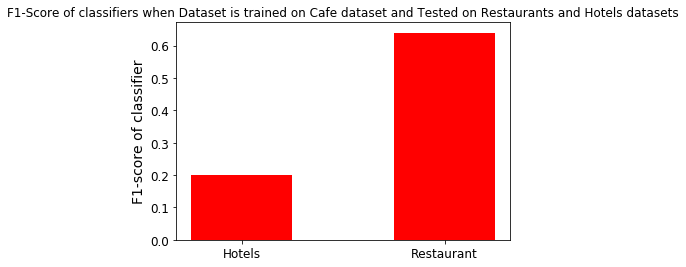

In [94]:
values = [0.20, 0.64]
names = ['Hotels','Restaurant']
plt.figure(figsize=(6,4))
# set up the bar chart
plt.bar(names, values, color="Red", width=0.5)
plt.title("F1-Score of classifiers when Dataset is trained on Cafe dataset and Tested on Restaurants and Hotels datasets", fontsize=12)
plt.ylabel("F1-score of classifier", fontsize=14)
# increase the font sizes on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [95]:
# hotel on cafe model
y_pred_hotel = cafemodel.predict(X_test_hotel)

# Confusion matrix for the hotel dataset
confmatrix = confusion_matrix(y_test_hotel , y_pred_hotel)
print("Classification Report :\n")
print(classification_report(y_test_hotel, y_pred_hotel, target_names=["positive","negative"]))

Classification Report :

              precision    recall  f1-score   support

    positive       0.24      0.18      0.21       243
    negative       0.52      0.60      0.56       357

    accuracy                           0.43       600
   macro avg       0.38      0.39      0.38       600
weighted avg       0.40      0.43      0.41       600



In [96]:
# hotel on restaurant model
y_pred_hotel = restaurantmodel.predict(X_test_hotel)

# Confusion matrix for the hotel dataset
confmatrix = confusion_matrix(y_test_hotel , y_pred_hotel)
print("Classification Report :\n")
print(classification_report(y_test_hotel, y_pred_hotel, target_names=["positive","negative"]))

Classification Report :

              precision    recall  f1-score   support

    positive       0.34      0.28      0.30       243
    negative       0.56      0.63      0.59       357

    accuracy                           0.48       600
   macro avg       0.45      0.45      0.45       600
weighted avg       0.47      0.48      0.47       600



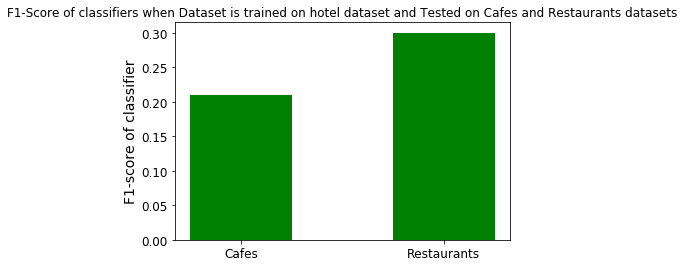

In [98]:
values = [0.21, 0.30]
names = ['Cafes','Restaurants']
plt.figure(figsize=(6,4))
# set up the bar chart
plt.bar(names, values, color="Green", width=0.5)
plt.title("F1-Score of classifiers when Dataset is trained on hotel dataset and Tested on Cafes and Restaurants datasets", fontsize=12)
plt.ylabel("F1-score of classifier", fontsize=14)
# increase the font sizes on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [99]:
# restaurant on cafe model
y_pred_restaurant = cafemodel.predict(X_test_restaurant)

# Confusion matrix for the restaurant dataset
confmatrix = confusion_matrix(y_test_restaurant , y_pred_restaurant)
print("Classification Report :\n")
print(classification_report(y_test_restaurant, y_pred_restaurant, target_names=["positive","negative"]))

Classification Report :

              precision    recall  f1-score   support

    positive       0.74      0.51      0.60       258
    negative       0.70      0.87      0.77       342

    accuracy                           0.71       600
   macro avg       0.72      0.69      0.69       600
weighted avg       0.72      0.71      0.70       600



In [100]:
# restaurant on hotel model
y_pred_restaurant = hotelmodel.predict(X_test_restaurant)

# Confusion matrix for the restaurant dataset
confmatrix = confusion_matrix(y_test_restaurant , y_pred_restaurant)
print("Classification Report :\n")
print(classification_report(y_test_restaurant, y_pred_restaurant, target_names=["positive","negative"]))

Classification Report :

              precision    recall  f1-score   support

    positive       0.20      0.12      0.15       258
    negative       0.48      0.62      0.54       342

    accuracy                           0.41       600
   macro avg       0.34      0.37      0.35       600
weighted avg       0.36      0.41      0.37       600



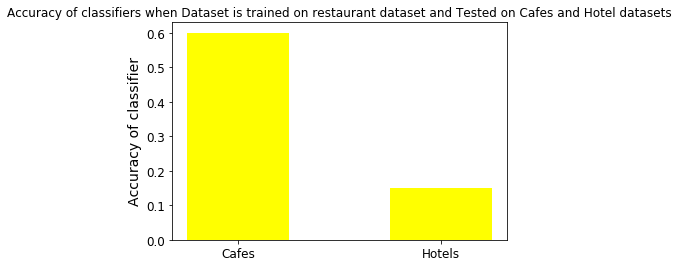

In [101]:
values = [0.60, 0.15]
names = ['Cafes','Hotels']
plt.figure(figsize=(6,4))
# set up the bar chart
plt.bar(names, values, color="Yellow", width=0.5)
plt.title("Accuracy of classifiers when Dataset is trained on restaurant dataset and Tested on Cafes and Hotel datasets", fontsize=12)
plt.ylabel("Accuracy of classifier", fontsize=14)
# increase the font sizes on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

## Summary

Here, we have compared three different dataset with thier F1 score
In Cafe model, I have first trained the model and then predicted on hotel and restaurant from which T recieve the F1 score of 0.20 and 0.64 respectively 
In the hotel model, , I have again trained the model and then predicted on cafe and restaurant from which I recieve the F1 score of 0.21 and 0.30 respectively 
In the restaurant model, , I have again trained the model and then predicted on cafe and hotel from which I recieve the F1 score of 0.60 and 0.15 respectively 

## Conclusion

As per the description of the question we have performed three tasks such as preprocessing, building a classification model and then evaluated the performance with each of them. We have learnt different preprocessing technique while mining text and classifying it as positive or negative. We have learnt difference measures used while building a classification model. We have learnt to plot and compare 3 different types of dataset but still relatable with each other. 

## Future Scope

We can use this data to analyse the dependencies on each other. Moreover we have other algorithms such as decision tree, Random forest, KNN, etc. We can also compare these algorithm and find which one has better accuracy and F1 score. These score can build a machine learning model and guess for the test data. It is used to train machine learning model. We can also train robots to increase the accuracy of its guesses. In Future Data science has many deep roots.